# XGB Models

The Data will be split by week and use week 9 as a validation set 

The Workflow will be as follow: 

    ** Use the default xgbregresor to train and plot feature importance
    ** Use a gridsearch to find the ideal hyperparameters (with only 50 estimators) 
    ** Train using all data and 500 estimators as our final model 
    

## Imports 

In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

C:\Anaconda\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
import pandas as pd
import numpy as np
import re 
import os
import time
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.cross_validation import LabelKFold
from sklearn.grid_search import GridSearchCV
import seaborn as sns
%matplotlib inline

## Util functions

In [3]:
# Load computed Dataset
def load_dataset(folder = ''):
    
    
    filename = "jorge_dataset.csv"
    filepath = os.path.join(folder,filename)        
    
    df_train = pd.read_csv(filepath,
                           usecols = ['Semana','Producto_ID', 'Cliente_ID', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'ZipCode',
                                      'Mean2','Mean3','Mean4','Mean6','Mean7',
                                      'Median2','Median3','Median4','Median6','Median7',
                                      'Last_per_Ruta_SAK','Last_per_Cliente_ID',
                                      'id',
                                      'Demanda_uni_equil'],
                           dtype  = {'Producto_ID':'int32',
                                     'Semana':'int8',
                                     'Cliente_ID':'int32',
                                     'Agencia_ID':'uint16',
                                     'Canal_ID':'int8',
                                     'Ruta_SAK':'int32',
                                     'ZipCode':'int16',                                     
                                     'Mean2':'float32','Mean3':'float32','Mean4':'float32',
                                     'Mean6':'float32','Mean7':'float32',
                                     'Median2':'float32','Median3':'float32','Median4':'float32',
                                     'Median6':'float32','Median7':'float32',
                                     'Last_per_Ruta_SAK':'float32','Last_per_Cliente_ID':'float32',
                                     'Demanda_uni_equil':'float32'})
    return df_train

## Load Dataset 

In [4]:
df = load_dataset()

In [5]:
print df.columns
display(df.head())
print df.dtypes

Index([u'Agencia_ID', u'Canal_ID', u'Cliente_ID', u'Demanda_uni_equil',
       u'Producto_ID', u'Ruta_SAK', u'Semana', u'ZipCode', u'id',
       u'Last_per_Cliente_ID', u'Last_per_Ruta_SAK', u'Mean3', u'Median3',
       u'Mean2', u'Median2', u'Mean4', u'Median4', u'Mean7', u'Median7',
       u'Mean6', u'Median6'],
      dtype='object')


,Agencia_ID,Canal_ID,Cliente_ID,Demanda_uni_equil,Producto_ID,Ruta_SAK,Semana,ZipCode,id,Last_per_Cliente_ID,...,Mean3,Median3,Mean2,Median2,Mean4,Median4,Mean7,Median7,Mean6,Median6
0,1110,7,15766,1.386294,1212,3301,3,2008,0,1.609438,...,1.418015,1.609438,1.418015,1.609438,1.39578,1.098612,1.558283,1.609438,1.558283,1.609438
1,1110,7,15766,1.609438,1212,3301,4,2008,0,1.386294,...,1.418015,1.609438,1.418015,1.609438,1.39578,1.098612,1.558283,1.609438,1.558283,1.609438
2,1110,7,15766,1.791759,1212,3301,5,2008,0,1.609438,...,1.418015,1.609438,1.418015,1.609438,1.39578,1.098612,1.558283,1.609438,1.558283,1.609438
3,1110,7,15766,1.609438,1212,3301,8,2008,0,1.791759,...,1.418015,1.609438,1.418015,1.609438,1.39578,1.098612,1.558283,1.609438,1.558283,1.609438
4,1110,7,15766,0.693147,1212,3301,9,2008,0,1.609438,...,1.418015,1.609438,1.418015,1.609438,1.39578,1.098612,1.558283,1.609438,1.558283,1.609438


Agencia_ID              uint16
Canal_ID                  int8
Cliente_ID               int32
Demanda_uni_equil      float32
Producto_ID              int32
Ruta_SAK                 int32
Semana                    int8
ZipCode                  int16
id                       int64
Last_per_Cliente_ID    float32
Last_per_Ruta_SAK      float32
Mean3                  float32
Median3                float32
Mean2                  float32
Median2                float32
Mean4                  float32
Median4                float32
Mean7                  float32
Median7                float32
Mean6                  float32
Median6                float32
dtype: object



#### Since I use Last -> Discard Week 3

#### Test data is week 10 and 11

In [6]:
df.Demanda_uni_equil[df.Demanda_uni_equil < 0] = 0
df_validation = df[df.Semana == 9]
df_train = df[(df.Semana != 3) & (df.Semana != 9) & (df.Semana < 10)]
df_test = df[df.Semana > 9]
del df

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [7]:
# Remove Columns that are not features 
#drop_columns = ['id','Semana','Demanda_uni_equil','DemandaAgencia_ID','DemandaCanal_ID','DemandaRuta_SAK','DemandaZipCode']
drop_columns = ['id','Semana','Demanda_uni_equil']

model_002 = ['ZipCode','Cliente_ID','Agencia_ID','Ruta_SAK']
model_003 = ['ZipCode','Cliente_ID','Agencia_ID','Ruta_SAK','Producto_ID','Canal_ID','DemandaRuta_SAK']


In [8]:
Semana = df_train.Semana
X_train = df_train.drop(drop_columns,axis=1)
#X_train = X_train.drop(model_003,axis=1)

X_valid = df_validation.drop(drop_columns,axis=1)
#X_valid = X_valid.drop(model_003,axis=1)

X_test = df_test.drop(drop_columns,axis=1)
#X_test = X_test.drop(model_003,axis=1)

Y_train = df_train['Demanda_uni_equil']
Y_test = df_test['Demanda_uni_equil']
Y_valid = df_validation['Demanda_uni_equil']



# Feature Importance 

### Lets train a default model and see the feature importance plot

In [9]:
gbm = xgb.XGBRegressor(seed=1234)
%time gbm.fit(X_train, Y_train, eval_metric='rmse', verbose=True)

Wall time: 23min 7s


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=1)

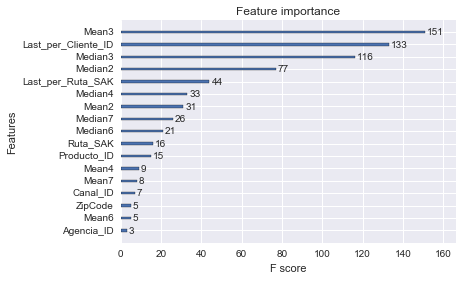

In [10]:
plt.figure(figsize=(10, 10))
xgb.plot_importance(gbm.booster())

## Parameter Tuning (YaY!) 

#### Cross-Validation and GridSearch
     Since I'm using xgboost I'm going to use the sklearn API so I can use GridSearchCV
          
http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html

    Also, Since this is not just normal data where each row is a data point but each point correspond to a point in a sequence (Weekly delivers). I'm going to use the 'Semana' to create the folds, for this refer to sklearn Label KFold 

http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.LabelKFold.html#sklearn.cross_validation.LabelKFold

### GridSearch 

    Pretty common grid 
    
        * Max depth of the tree
        * n estimators: # Trees
        * Learning Rate
        * subsample
        * alpha and lambda regs
        
please refer:
http://xgboost.readthedocs.io/en/latest/python/python_api.html

In [ ]:
param = {'max_depth':[10,6], 
        'n_estimators':[50] ,
        'learning_rate':[0.1,0.05],         
         'subsample': [0.5,1],
         #'reg_alpha':[0,1], #L2 term
         #'reg_lambda':[0,1]#, #L1 tem            
         #'silent': [False]
        }

best_param = {'max_depth':[10], 
        'n_estimators':[100] ,
        'learning_rate':[0.1],         
         'subsample': [1],
         #'reg_alpha':[0,1], #L2 term
         #'reg_lambda':[0,1]#, #L1 tem            
         #'silent': [False]
        }

I tried the gridsearch with CV, takes too long in my machine (4Cores 28GB) I gave up at 12hrs running.

# GO! 
###### and probably get a coffe

In [ ]:
grid_scores_ = pd.DataFrame(columns=['max_depth','learning_rate','n_estimators','subsample','score' ])
from sklearn.grid_search import ParameterGrid

for g in ParameterGrid(param):
    start = time.time()
    
    grid_gbm = xgb.XGBRegressor(**g)
    grid_gbm.fit(X_train, Y_train,eval_set=[(X_valid,Y_valid)] ,eval_metric='rmse')
    
    print "Score for this combination: ", grid_gbm.evals_result_.values()[-1].values()[-1][-1]
    g['rmse'] = grid_gbm.evals_result_.values()[-1].values()[-1][-1] #I'm sure there must be a better way to get this, but this nested dict is annoying
    grid_scores_ = grid_scores_.append(g, ignore_index=True)
            
    print("total time taken this loop: ", time.time() - start)

    
    
display(grid_scores_)    
#print "OOB: %0.5f" % best_score 
#print "Grid:", best_grid

[0]	validation_0-rmse:1.25188
[1]	validation_0-rmse:1.1382
